# Data Mining and Machine Learning - Project

## Detecting Difficulty Level of French Texts Using Decison Tree Classification.

Import the main packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

Read the training data.

In [4]:
df = pd.read_csv('training_data.csv')
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


Read the unlabelled test data, on which to make predictions.

In [5]:
df_pred = pd.read_csv('unlabelled_test_data.csv')
df_pred.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


The submission format is the following:

In [6]:
df_example_submission = pd.read_csv('sample_submission.csv')
df_example_submission.head()

,id,difficulty
0,0,A1
1,1,A1
2,2,A1
3,3,A1
4,4,A1


### Check the value of the baseline
Check the baseline to have a better understanding of the precision of the classification.

In [7]:
np.random.seed = 0

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [9]:
# Define x and y, and the respective training data and test data
x = df['sentence']
y = df['difficulty']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [10]:
# Baseline - using dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

dummy.fit(None, y_train)
baseline = dummy.score(None, y_test)

print('The value of the baseline in our data is',baseline.round(4))

The value of the baseline in our data is 0.1677


In [11]:
# Baseline - identifying the most frequent difficulty
df.difficulty.value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

In [12]:
baseline2 = round(df.difficulty.value_counts()['A1']/len(df),4)

print('The value of the baseline in our data is',baseline2.round(5))

The value of the baseline in our data is 0.1694


#### 4.4. Decision Tree Classifier (without data cleaning)

Train a Decison Tree classifier, using a Tfidf vectoriser.

In order to classify text, we need to use a vectorizer and also import certain packages. It is also important to note that while installing the packages, you must import the correct language you will be classifying.

In [ ]:
# Install and update spaCy
!pip install -U spacy
!python -m spacy download fr

# Import necessary packages
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
import string
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.fr import French
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Define the vectorizer and the classification method that will be used, once those are defined, create a pipeline to classify the training set.

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
dtc = DecisionTreeClassifier(random_state=0)

pipe = Pipeline([("tokenizer",tfidf),
                ("classifier",dtc)])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

In order to analyse our results, we calculated the accuracy, precision, recall and F1 score on the test set, besides plotting the confusion matrix.

In [17]:
def evaluate(true, pred):
    global precision,recall,f1
    precision = precision_score(true, pred, average='weighted')
    recall = recall_score(true, pred, average='weighted')
    f1 = f1_score(true, pred, average='weighted')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [18]:
evaluate(y_test,y_pred)

CONFUSION MATRIX:
[[79 35 12 18 14  3]
 [44 55 24 23  7 11]
 [16 34 39 27 24 20]
 [ 4 15 30 29 37 29]
 [ 5 13 24 40 44 47]
 [ 5 17 21 39 31 45]]
ACCURACY SCORE:
0.3031
CLASSIFICATION REPORT:
	Precision: 0.3085
	Recall: 0.3031
	F1_Score: 0.3053


In order to improve the classification, we tuned the hyper parameters for `max_depth`

In [19]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = Pipeline([("tokenizer",tfidf),("decision_tree_classifier",DecisionTreeClassifier(max_depth=depth))])
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    #ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    #ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [20]:
test_accuracy_score  = []
train_accuracy_score = []
for i in range(100,121):
    pipelinedt = Pipeline([("tokenizer",tfidf),
                         ("decision_tree_classifier",DecisionTreeClassifier(max_depth=i,random_state=0))])
    pipelinedt.fit(x_train,y_train)
    tree_predictions = pipelinedt.predict(x_test)
    tree_predictions_train = pipelinedt.predict(x_train)
    test_accuracy_score.append(accuracy_score(y_test,tree_predictions))
    train_accuracy_score.append(accuracy_score(y_train,tree_predictions_train))

(15, 0.3145833333333333)

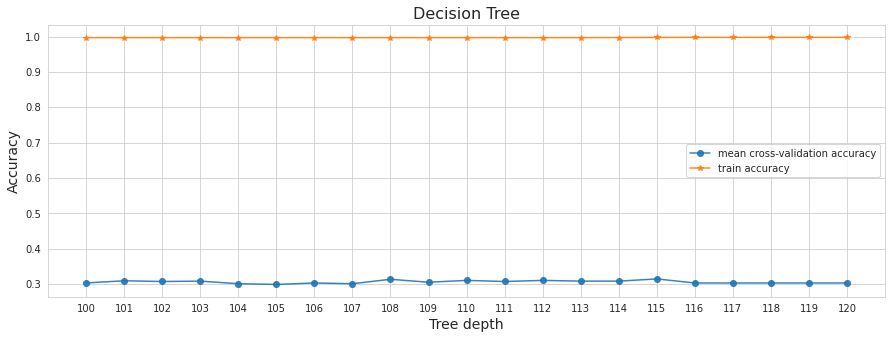

In [21]:
plot_cross_validation_on_trees(depths=range(100,121), cv_scores_mean=test_accuracy_score, accuracy_scores=train_accuracy_score,title="Decision Tree",cv_scores_std=0)
max = pd.Series(test_accuracy_score).argmax()
pd.Series(test_accuracy_score).argmax(),pd.Series(test_accuracy_score).max()

With the new parameters, we run the classification once more, to try to get better results.

In [22]:
dtc = DecisionTreeClassifier(max_depth=100+max,random_state=0)

pipelinedtc = Pipeline([("tokenizer",tfidf),
                     ("classifier",dtc)])
pipelinedtc.fit(x_train,y_train)

y_predDTC = pipelinedt.predict(x_test)

To check the results, we evaluate the new predictions.

In [23]:
evaluate(y_test,y_predDTC)

CONFUSION MATRIX:
[[79 35 12 18 14  3]
 [44 55 24 23  7 11]
 [16 34 39 27 24 20]
 [ 4 15 30 29 37 29]
 [ 5 13 24 40 44 47]
 [ 5 17 21 39 31 45]]
ACCURACY SCORE:
0.3031
CLASSIFICATION REPORT:
	Precision: 0.3085
	Recall: 0.3031
	F1_Score: 0.3053


Now we can generate predictions on the unlabelled_test_data.csv, insuring that they match the format of the unlabelled_test_data.csv in order to submit them.

In [25]:
x_pred = df_pred['sentence']

y_prediction_dt = pipelinedtc.predict(x_pred)

In [26]:
df_pred_dt = df_pred
df_pred_dt['difficulty'] = y_prediction_dt
df_submission_dt = df_pred_dt.drop(['sentence'], axis=1)
df_submission_dt.to_csv('subimissiondt.csv',index=False)
df_submission_dt.head()

,id,difficulty
0,0,C1
1,1,B1
2,2,A2
3,3,C2
4,4,B2
